## RATINGS PREDICTION 

In [ ]:
 #Importing necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re           # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

#Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Read the csv file into dataframe df
df= pd.read_csv('Ratings_Scrapping.csv')

### Data Overview

In [ ]:
df.tail(5)

Unnamed: 0  ... Product Rating
39995       39995  ...            3.0
39996       39996  ...            4.0
39997       39997  ...            3.0
39998       39998  ...            1.0
39999       39999  ...            1.0

[5 rows x 3 columns]

In [ ]:
#Checking number of rows and coloumns in train and test data
print(df.shape)

(40000, 3)


### Checking and removing null values

In [ ]:
#Checking if there are some missing values or not in train and test data.
print(df.isnull().sum())

Unnamed: 0          0
Product Review    200
Product Rating      0
dtype: int64


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df['Product Review'].fillna('No review',inplace=True)

In [ ]:
df.isnull().sum()

Product Review    0
Product Rating    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Product Review  40000 non-null  object 
 1   Product Rating  40000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
#Let's figure out how many users give title to their reviews.
rev = df['Product Review'].count()
print(" Total no. of people who gave Review title in data are " + str(rev))

 Total no. of people who gave Review title in data are 40000


##### Observation:
1.We can clearly see that users who gave 1 star as well as 5 stars always write "Review Title".

2.This can affect our review page alot on website because title fits into eyes of reader first.

In [ ]:
#Let's see the Average Star rating
avg = df['Product Rating'].mean()
Avg = round(avg,1)
print("Average rating given by users is " + str(Avg))

Average rating given by users is 3.2


In [ ]:
# Check the rating distribution
df['Product Rating'].value_counts()

5.0    13760
1.0    13340
4.0     7560
3.0     3560
2.0     1780
Name: Product Rating, dtype: int64

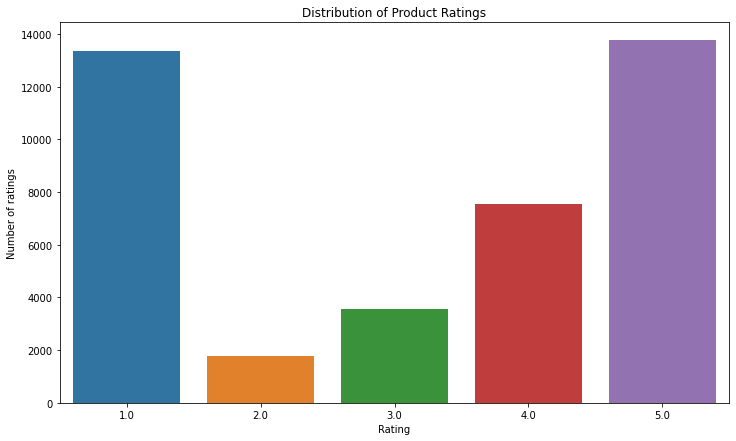

In [ ]:
# Visualize the rating distribution
f, axes = plt.subplots(figsize=(12,7))
ax = sns.countplot(x=df['Product Rating'])
ax.set(title="Distribution of Product Ratings", xlabel="Rating", ylabel="Number of ratings")
plt.show()

In [ ]:
sns.countplot()

In [ ]:
# Check the statistical summary for the ratings
df.describe()

Product Rating
count    40000.000000
mean         3.165500
std          1.707683
min          1.000000
25%          1.000000
50%          4.000000
75%          5.000000
max          5.000000

#### Preprocessing involved the following steps:
- Removing Punctuations and other special characters
- Splitting the comments into individual words
- Removing Stop Words
- Stemming and Lemmatising
- Applying Count Vectoriser
- Splitting dataset into Training and Testing

In [ ]:
df['Product Review'][5]

'Dumbbest laptop at the dumbbest price4 lakh ha ha haGo for the other ha waste of money guys'

In [ ]:
import nltk 
from nltk.corpus import stopwords
import string

In [ ]:
import nltk
nltk.download('stopwords')

def clean_text(df, df_column_name):
  # Convert all messages to lower case
  df[df_column_name] = df[df_column_name].str.lower()

  # Replace email addresses with 'email'
  df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                  'emailaddress')

  # Replace URLs with 'webaddress'
  df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                    'webaddress')

  # Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
  df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                    'phonenumber')

  # Replace numbers with 'numbr'
  df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

  # Remove punctuation
  df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

  # Replace whitespace between terms with a single space
  df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

  # Remove leading and trailing whitespace
  df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
  # Remove stopwords
  stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
  df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
clean_text(df, 'Product Review')
df['Product Review'].tail(3)

39997    poor quality plastic locks broke back opened f...
39998    purchase working software corrpted switching n...
39999    good much lagging issues please buywaste money...
Name: Product Review, dtype: object

In [ ]:
df['Product Review'][5]

'dumbbest laptop dumbbest pricenumbr lakh ha ha hago ha waste money guys'

### Stemming and Lemmatizing 

The wordnet library in nltk will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


lem=WordNetLemmatizer()
df['Product Review'] = df['Product Review'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Getting sense of loud words in star Rating 
from wordcloud import WordCloud

rating = df['Product Review']
word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(rating)
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Feature Extraction:

#### Applying Vectorizer
Here we can finally convert our text to numeric using TfidfVectorizer.

In [ ]:
#import required library
from sklearn.feature_extraction.text import TfidfVectorizer

#create object
tf = TfidfVectorizer()

#fitting 
features = tf.fit_transform(df['Product Review'])
x=features
y=df[['Product Rating']]


#### Implementation :

In [ ]:
#Importing necessary library for model building
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
#defining a function to find fit of the model
def max_acc_score(names,model_c,x,y):
    accuracy_scr_max = 0
    x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 42,test_size = 0.2,stratify = y)
    model_c.fit(x_train,y_train)
    accuracy_scr = accuracy_score(y_test,model_c.predict(x_test))
    if accuracy_scr> accuracy_scr_max:
      accuracy_scr_max=accuracy_scr
      final_model = model_c
      mean_acc = cross_val_score(final_model,x,y,cv=5,scoring="accuracy").mean()
      std_dev = cross_val_score(final_model,x,y,cv=5,scoring="accuracy").std()
      cross_val = cross_val_score(final_model,x,y,cv=5,scoring="accuracy")
    print("*"*50)
    print("Results for model : ",names,'\n',
          "max accuracy score correspond to random state is" , accuracy_scr_max ,'\n',
          "Mean accuracy score is : ",mean_acc,'\n',
          "Std deviation score is : ",std_dev,'\n',
          "Cross validation scores are :  " ,cross_val) 
    print("*"*50)

In [ ]:
#Now by using multiple Algorithms we are calculating the best Algo which performs best for our data set 
accuracy_scr_max = []
models=[]
accuracy=[]
std_dev=[]
mean_acc=[]
cross_val=[]
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))
models.append(("MultinomialNB",MultinomialNB()))

for names,model_c in models:
    max_acc_score(names,model_c,x,y)
    

**************************************************
Results for model :  Logistic Regression 
 max accuracy score correspond to random state is 0.919 
 Mean accuracy score is :  0.599475 
 Std deviation score is :  0.06402950491765495 
 Cross validation scores are :   [0.6505   0.502    0.627    0.547875 0.67    ]
**************************************************
**************************************************
Results for model :  Random Forest 
 max accuracy score correspond to random state is 0.919 
 Mean accuracy score is :  0.6134250000000001 
 Std deviation score is :  0.08704745832016005 
 Cross validation scores are :   [0.6255   0.512    0.60175  0.625375 0.5575  ]
**************************************************
**************************************************
Results for model :  KNN 
 max accuracy score correspond to random state is 0.914875 
 Mean accuracy score is :  0.5478999999999999 
 Std deviation score is :  0.05769485462326776 
 Cross validation scores are :  

##### Observation:

1. From initial model values RandomForest and Logistic Regressions are performing better than others.

In [ ]:
# Estimating best n_estimator using grid search for Randomforest Classifier

from sklearn.model_selection import train_test_split,GridSearchCV
parameters={"n_estimators":[1,10,100]}
rf_clf=RandomForestClassifier()
clf = GridSearchCV(rf_clf, parameters, cv=5,scoring="accuracy")
clf.fit(x,y)
print("Best parameter : ",clf.best_params_)

Best parameter :  {'n_estimators': 100}


In [ ]:
#Again running RFC with n_estimator = 100
rf_clf=RandomForestClassifier(n_estimators=100,random_state=42)
max_acc_score("RandomForest Classifier",rf_clf,x,y)

**************************************************
Results for model :  RandomForest Classifier 
 max accuracy score correspond to random state is 0.919 
 Mean accuracy score is :  0.597925 
 Std deviation score is :  0.07506120835691363 
 Cross validation scores are :   [0.7005   0.467    0.60175  0.600375 0.62    ]
**************************************************


In [ ]:
#Estimating parameters of Linear Regression for best fit
log_rg=LogisticRegression()
parameters={"C":[0.001,0.01,0.1,1,10] }
clf = GridSearchCV(log_rg, parameters, cv=5,scoring="accuracy")
clf.fit(x,y)
print("Best parameter : ",clf.best_params_)

Best parameter :  {'C': 0.1}


In [ ]:
#Again running Logistic regression with best parameter (C=0.1)
log_rg=LogisticRegression(C=0.1)
max_acc_score("Logistic Regression" ,log_rg,x,y)

**************************************************
Results for model :  Logistic Regression 
 max accuracy score correspond to random state is 0.918875 
 Mean accuracy score is :  0.647975 
 Std deviation score is :  0.049073439863127594 
 Cross validation scores are :   [0.6755   0.5545   0.6945   0.647875 0.6675  ]
**************************************************


##### Observation:
   1.Clearly Random Forest Classifier is performing best as accuracy score is closest to 1 so we will use it for further analysis.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x, y,random_state = 42,test_size=0.20,stratify=y)
rf_clf.fit(x_train,y_train)
y_pred=rf_clf.predict(x_test)

accuracy score is :  0.919
classification report 
               precision    recall  f1-score   support

         1.0       0.88      0.96      0.92      2668
         2.0       0.91      0.81      0.86       356
         3.0       0.91      0.83      0.87       712
         4.0       0.93      0.93      0.93      1512
         5.0       0.96      0.91      0.93      2752

    accuracy                           0.92      8000
   macro avg       0.92      0.89      0.90      8000
weighted avg       0.92      0.92      0.92      8000



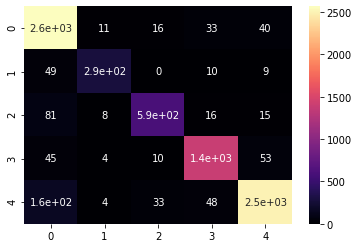

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print("accuracy score is : ",accuracy_score(y_test,y_pred))
print("classification report \n",classification_report(y_test,y_pred))

cnf = confusion_matrix(y_test,y_pred)
sns.heatmap(cnf, annot=True, cmap = "magma")

Conclusions :

a. Taken output variable as Product Rating(split into five category i.e. 1.0,2.0,3.0,4.0,5.0)stars rating.

b. Found best model as RandomForest classifier(selected on basis of accuracy score) at random state 42 which provides max accuracy score of 0.919.

c. Plotted confusion matrix, std deviation mean = 0.07 , accuracy =0.919

d. Overall model fit is good.

### Saving the Model

In [ ]:
import joblib
#save the model as a pickle in a file 
joblib.dump(rf_clf,'rf_RatingPrediction.pkl')

['rf_RatingPrediction.pkl']